In [1]:
import librosa
import librosa.display
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
#%pip install noisereduce
import noisereduce as nr
import soundfile as sf
import os
import pandas as pd
import time
from IPython.display import clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

ModuleNotFoundError: No module named 'noisereduce'

In [25]:
def extract_spectrogram(file_path, duration = 4): 
    #cargar audios
    Audio, Sample = librosa.load(file_path)
    numMuestras = duration*Sample
    #gggg
    #ajuste la duracion 
    if len(Audio)>numMuestras:
        Audio = Audio[:Sample*4]
    else:
        silence = np.zeros(numMuestras-len(Audio))
        Audio = np.concatenate([Audio,silence])
    
    #guardado y generacion de espectograma
    spect = librosa.stft(Audio)
    spectInDb = librosa.amplitude_to_db(spect)
    return spectInDb

def importAudios(audio_path, metadata, features, labels, top = 2999):
    #inicializo variables para contabilizar el numero de audios
    numGun=0
    numNoGun=0
    
    for index, row in metadata.iterrows():
        file_name = os.path.join(audio_path, f"fold{row['fold']}", row['slice_file_name'])
    
        class_id = row['classID']
        # Etiquetar como '1' si classID es 6, de lo contrario como '0'
        class_label = 1.0 if class_id == 6 else 0.0
        if numGun>top: 
            print("skip")
            break
        if numNoGun>top and class_label != 1.0:
            continue
        numGun, numNoGun = numGun + (class_label == 1), numNoGun + (class_label != 1)
        # Extraer características y etiquetas
        data = extract_spectrogram(file_name) 
        features.append(data)
        labels.append(class_label) 
    print(f"lungitud: {len(features)}")
    print(f"num G:{numGun}, num no G:{numNoGun}")
    return features, labels

def extract_properties(file_path):
    audio, dsfds = librosa.load(file_path)
    spect = librosa.stft(audio)
    spect_db = librosa.amplitude_to_db(spect, ref=np.max)
    n_bands, n_frames = spect_db.shape
    
    return n_bands, n_frames

In [26]:
metadata = pd.read_csv('../UrbanSound8K.csv')

audio_path = 'C:/Users/HudayPlata/Documents/Unimag Tesis/Audio Tesis/Audio_Datasets'
print(metadata.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [27]:
features = []
labels = []
features, labels = importAudios(audio_path, metadata, features, labels)
n_bands, n_frames = extract_properties(audio_path +"/fold5/100263-2-0-117.wav")
print(f"{n_bands}, { n_frames}")

C:\Users\HudayPlata\AppData\Local\Temp\ipykernel_171960\2140010075.py:15: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectInDb = librosa.amplitude_to_db(spect)


lungitud: 3374
num G:374, num no G:3000
1025, 173


C:\Users\HudayPlata\AppData\Local\Temp\ipykernel_171960\2140010075.py:46: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spect_db = librosa.amplitude_to_db(spect, ref=np.max)


In [28]:
print(f"{features[1].shape}")
all_same_shape = all(f.shape == (1025, 173) for f in features)
print(f"All arrays have the shape (1025, 173): {all_same_shape}")

(1025, 173)
All arrays have the shape (1025, 173): True


In [29]:
# Convertir las listas a arrays de numpy 
X = np.array(features)
y = np.array(labels)

In [30]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

2361 1013
2361 1013


In [31]:
# Crear el modelo CRNN
model = Sequential()

# Parte CNN
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1025, 173, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
print(model.layers[-1].output)
model.add(Flatten())
# Capa de salida
print(model.layers[-1].output)
model.add(Dense(1, activation='sigmoid'))
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("ok")
print(model.summary())

c:\Users\HudayPlata\Documents\Unimag Tesis\Tesis Code\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<KerasTensor shape=(None, 509, 41, 64), dtype=float32, sparse=False, name=keras_tensor_32>
<KerasTensor shape=(None, 1335616), dtype=float32, sparse=False, name=keras_tensor_37>
ok


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 1023, 171, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 511, 85, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 509, 83, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 509, 41, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1335616)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │     1,335,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,433 (5.17 MB)

 Trainable params: 1,354,433 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=5, batch_size=10)

# Guardar el modelo entrenado
model.save('gunshot_detection_model_NEW.h5')

# Evaluar el modelo en el conjunto de prueba
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {score[1]}')

# Predicciones en el conjunto de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 130s 535ms/step - accuracy: 0.9217 - loss: 17.8754
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 128s 540ms/step - accuracy: 0.9812 - loss: 0.1069
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 111s 468ms/step - accuracy: 0.9965 - loss: 0.0145
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 124s 521ms/step - accuracy: 0.9878 - loss: 0.1282
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 114s 481ms/step - accuracy: 0.9882 - loss: 0.0449


Accuracy: 0.9605133533477783
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step


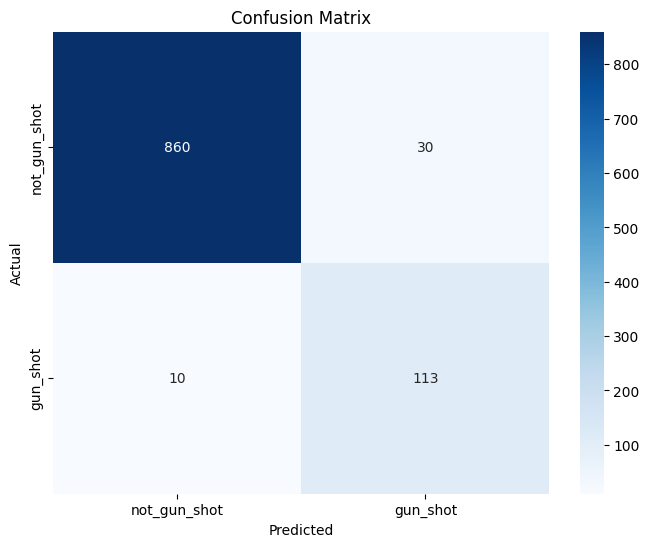

              precision    recall  f1-score   support

not_gun_shot       0.99      0.97      0.98       890
    gun_shot       0.79      0.92      0.85       123

    accuracy                           0.96      1013
   macro avg       0.89      0.94      0.91      1013
weighted avg       0.96      0.96      0.96      1013



In [33]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['not_gun_shot', 'gun_shot'], columns=['not_gun_shot', 'gun_shot'])

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['not_gun_shot', 'gun_shot'])
print(report)